In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
from Bio import SeqIO
import csv
import scipy
from scipy import stats
import pybedtools
from matplotlib_venn import venn3, venn3_circles,venn3_unweighted,venn2
import seaborn as sns
from pandas import DataFrame


# Initialisation

In [3]:
tool="HISAT2"
sample="NA12878"
callers=["GATK","samtools"]
assembler="StringTie"
editor="GIREMI"


NIST_vcf="/path/to/NISTIntegratedCalls_14datasets\
_131103_allcall_UGHapMerge_HetHomVarPASS_VQSRv2.19_2mindatasets_5minYesNoRatio_all_nouncert_excludesimplerep\
_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs.vcf"
NIST_HC_exon_bed="/path/to//NIST_HC_exon.bed"
NIST_HC_bed="/path/to//union_NIST_HC.bed"
Exon_bed="/path/to//genes.GRCh37.gtf.exons.bed"
dbsnp_vcf="/path/to//dbsnp_138.b37.vcf"
ref_gtf_ensemble="/path/to//genes.GRCh37.gtf"
b37_rmask_bed="/path/to//b37.rmask.bed"
b37_regions="/path/to//b37_regions"
Transcript_bed="/path/to/genes.GRCh37.gtf.transcripts.bed"
NIST_HC_transcript_bed="/path/to/NIST_HC_transcript.bed"
final_fwd=pybedtools.BedTool("/path/to/forward_pos.bed")
final_rev=pybedtools.BedTool("/path/to/reverse_pos.bed")
analysis_folder="/path/to/analysis_folder/"
varsim_jar="/path/to/VarSim.jar"

# Predictions

In [22]:
pred_vcf={}
pred_vcf["GATK"]="/path/to/output_filtered.vcf"
pred_vcf["samtools"]="/path/to/variants.vcf"
gtf_file="/path/to/transcripts.gtf"

# Functions

In [5]:
def vcf_to_bed(vcf_file,otherfields=[]):
    with open(vcf_file,"r") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        intervals=[]
        for row in spamreader:
            if row[0]=="#":
                continue
            if otherfields:
                intervals.append(pybedtools.Interval(row[0],int(row[1])-1,int(row[1]),otherfields=[row[i]
                                                                                        for i in otherfields]))
            else:
                intervals.append(pybedtools.Interval(row[0],int(row[1])-1,int(row[1])))                
    return pybedtools.BedTool(intervals)    

In [6]:
### generate_transcript_list
############################
def generate_transcript_bed(input_file):
    transcript_list=[]
    transcript_dict={}
    zero_fpkms=0
    cnt=0
    with open(input_file, 'r') as input_f:
        for line in input_f:
            if (line[0] == '#'):
                continue
            fields = line.strip().split()
            chrom=fields[0]
            start,end=sorted(map(int,fields[3:5]))
            exon_info ={k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}
            transcript_id=exon_info['transcript_id']
            if transcript_id not in transcript_dict:
                transcript_dict[transcript_id]=[chrom,start,end]
            else:
                transcript_dict[transcript_id]=[transcript_dict[transcript_id][0], 
                                                min(start,transcript_dict[transcript_id][1]),
                                                max(end,transcript_dict[transcript_id][2])]
    transcript_bed=pybedtools.BedTool([pybedtools.Interval(x[0],x[1],x[2]) for x in transcript_dict.values()]).sort()
    return transcript_bed



In [7]:
if not os.path.exists(Transcript_bed):
    a=generate_transcript_bed(ref_gtf_ensemble).saveas(Transcript_bed)
if not os.path.exists(NIST_HC_transcript_bed):
    b=pybedtools.BedTool(NIST_HC_bed).intersect(Transcript_bed).sort().saveas(NIST_HC_transcript_bed)

In [8]:
Alu_regions=pybedtools.BedTool(b37_rmask_bed
                      ).filter(lambda x: "Alu" in x.name).merge().sort()


In [9]:
reps=["repeats_b37_duplicates.bed","repeats_b37_Low_complexity.bed","repeats_b37_SINE.bed",
"repeats_b37_duplicates_unique.bed", "repeats_b37_Satellite.bed", "repeats_b37_LINE.bed", "repeats_b37_Simple_repeat.bed"]
rep_regions=pybedtools.BedTool([])
for rep in reps:
    rep_regions=rep_regions.cat("%s/%s"%(b37_regions,rep))
rep_regions=rep_regions.sort().merge()

In [10]:
nonAlu_rep_regions=rep_regions.subtract(Alu_regions).sort()

In [12]:
for caller in callers:
    if not os.path.exists("%s.exons.bed"%gtf_file):
        pybedtools.BedTool(sorted([[x[0],x[1],x[2],x[3]] for x in pybedtools.BedTool(
                        gtf_file).filter(
                        lambda y:y[2]=="exon").cut([0,3,4,2])],key=lambda z:[z[0],int(z[1]),int(z[2])])
                          ).merge().each(lambda x: [x[0],int(x[1])-1,int(x[2])+1]).saveas(
            "%s.exons.bed"%gtf)
    if not os.path.exists("%s.NIST_HC_exon.bed"%gtf_file):
        pybedtools.BedTool(
            NIST_HC_bed).intersect(
            "%s.exons.bed"%gtf_file).saveas(
            "%s.NIST_HC_exon.bed"%gtf_file)

    cmd="java -jar %s  vcfcompare -bed %s.NIST_HC_exon.bed -exclude_filtered -true_vcf %s -prefix \
    %s_%s_NISTHC %s"%(varsim_jar,gtf_file,NIST_vcf,pred_vcf[caller],assembler,pred_vcf[caller])
    if not os.path.exists("%s_%s_NISTHC_TP.vcf"%(pred_vcf[caller],assembler)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print a

    cmd="java -jar  %s vcfcompare -bed %s -exclude_filtered -true_vcf %s -prefix \
    %s_NISTHC %s"%(varsim_jar,NIST_HC_exon_bed,NIST_vcf,pred_vcf[caller],pred_vcf[caller])
    if not os.path.exists("%s_NISTHC_TP.vcf"%(pred_vcf[caller])):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print a


In [13]:
pred_res={}
for caller in callers:
    pred_res[caller]={}
    p_vcf=pred_vcf[caller]
    for res in ["TP","FP","FN"]:
        res_file="%s_%s_NISTHC_%s.vcf"%(p_vcf,assembler,res)
        with open(res_file,"r") as res_file_stram:
            cnt=0
            for line in res_file_stram:
                if not line[0]=="#":
                    cnt+=1
        pred_res[caller][res]=cnt
    pred_res[caller]["PR"]=round(pred_res[caller]["TP"]/float(
        pred_res[caller]["FP"]+pred_res[caller]["TP"]+0.00001),2)
    pred_res[caller]["SN"]=round(pred_res[caller]["TP"]/float(
        pred_res[caller]["FN"]+pred_res[caller]["TP"]+0.00001),2)
    pred_res[caller]["F1"]=round(2/float(1/float(pred_res[caller]["PR"]+0.00001
        )+1/float(pred_res[caller]["SN"]+0.00001)),2)


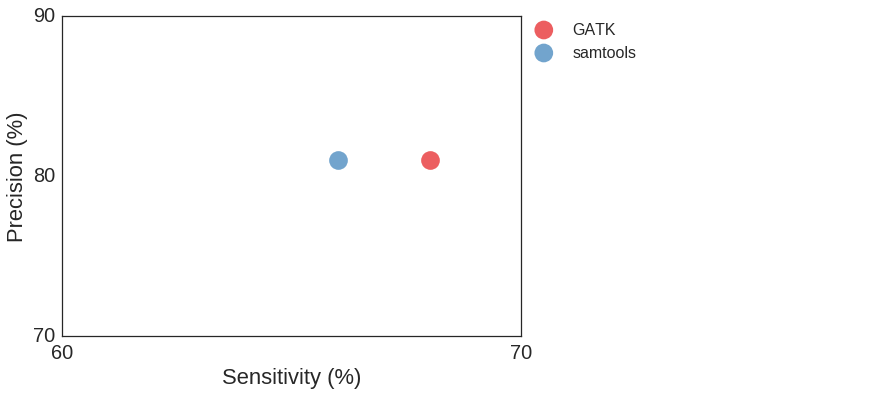

In [14]:
sns.set(style="white",font_scale=2)  
my_colors=sns.color_palette("Set1",n_colors=10)
fig, ax = plt.subplots(figsize=(8,6))
for iii,caller in enumerate(callers):
    x=(pred_res[caller]["PR"] if pred_res[caller] else 0) if pred_vcf[caller] else 0 
    y=(pred_res[caller]["SN"] if pred_res[caller] else 0) if pred_vcf[caller] else 0 
    z=(pred_res[caller]["F1"] if pred_res[caller] else 0) if pred_vcf[caller] else 0 
    label= caller
    ax.scatter(y*100, x*100, 350, alpha=0.7,linewidth=0,label=label,color=my_colors[iii])
ax.set_yticks(np.arange(70,100,10))
ax.set_ylim([70,90])
ax.set_xlim([60,70])
ax.set_xticks(np.arange(60,80,10))
ax.set_ylabel("Precision (%)")
ax.set_xlabel("Sensitivity (%)")
ax.legend(bbox_to_anchor=(1, .8,0.8, .2), loc=2,ncol=1,
mode="expand", borderaxespad=0.,frameon=False,fontsize=16)

plt.tight_layout()

In [15]:
def merge_info_strand(feature):
    if "-1" in feature[7]:
        return pybedtools.Interval(chrom=feature.chrom,start=feature.start,end=feature.end,name=feature.name,
                                   score=feature.score,strand=feature.strand)
    pos1=min(int(feature[1]),int(feature[7]))
    pos2=max(int(feature[2]),int(feature[8]))
    scores=[int(feature[4]),int(feature[10])]
    names=[feature[3],feature[9]]
    ind_min=sorted(enumerate(scores),key=lambda x:x[1])[0][0]
    return pybedtools.Interval(chrom=feature.chrom,start=pos1,end=pos2,name=names[ind_min],score=scores[ind_min],
                               strand=feature.strand)

In [16]:
edit_distrbution_all={}
revnt={"A":"T","C":"G","T":"A","G":"C"}
for caller in callers:
    edit_distrbution_all[caller]={}
    for res in ["FP","TP"]:
        edit_distrbution_all[caller][res]={}
        res_file="%s_%s_NISTHC_%s.vcf"%(pred_vcf[caller],assembler,res)
        res_bed=vcf_to_bed(res_file,otherfields=[3,4,7])
        snv_bed=res_bed.filter(lambda x: len(x[6])==1 and len(x[7])==1).sort().cut([0,1,2,6,7,3])
        n_indel=len(res_bed.filter(lambda x: len(x[6])!=1 or len(x[7])!=1))
        n_snv=len(snv_bed)

        my_final_fwd=final_fwd.sort()
        my_final_rev=final_rev.sort()






        SNV_fwd=snv_bed.window(my_final_fwd,w=0).sort().groupby(g=[1,2,3],c=[4,5,12],o="first,first,first")
        SNV_fwd1=snv_bed.window(my_final_fwd,w=0,v=True)
        SNV_fwd=SNV_fwd.cat(SNV_fwd1,postmerge=False).sort()

        SNV_rev=snv_bed.window(my_final_rev,w=0).sort().groupby(g=[1,2,3],c=[4,5,12],o="first,first,first")
        SNV_rev1=snv_bed.window(my_final_rev,w=0,v=True)
        SNV_rev=SNV_rev.cat(SNV_rev1,postmerge=False).sort()

        SNV_final=SNV_fwd.cat(SNV_rev,postmerge=False).sort().groupby(g=[1,2,3],c=[4,5,6],o="first,first,collapse")
        SNV_good_=SNV_final.filter(lambda x:len(set(x[5].split(","))-set("."))==1).sort()
        SNV_no=SNV_final.filter(lambda x:len(set(x[5].split(","))-set("."))==0).sort()
        SNV_bad_=SNV_final.filter(lambda x:len(set(x[5].split(","))-set("."))>1).sort()

        for call,snv_bed in  [["good",SNV_good_],["bad",SNV_bad_],["no",SNV_no]]:
            edit_distrbution_all[caller][res][call]={}
            for region,region_bed in [["Alu",Alu_regions],["nonAlu-reps",nonAlu_rep_regions],["nonreps",""],["all",""]]:
                if region in ["Alu","nonAlu-reps"]:
                    my_snv_bed=snv_bed.window(region_bed,w=0,u=True)
                elif region=="nonreps":
                    my_snv_bed=snv_bed.window(Alu_regions,w=0,v=True)
                    my_snv_bed=my_snv_bed.window(nonAlu_rep_regions,w=0,v=True)
                elif region=="all":
                    my_snv_bed=snv_bed.sort()
                else:
                    print "ERROR"
                    ERROR
                edit_types=[x[3]+x[4] if "+" in x[5] else revnt[x[3]]+revnt[x[4]] for x in my_snv_bed]
                edit_distrbution_all[caller][res][call][region]={
                    etype:edit_types.count(etype) for etype in set(edit_types)}
        print sample,tool,res,len(res_bed),n_indel,n_snv,\
                len(SNV_good_),len(SNV_no),len(SNV_bad_)



NA12878 HISAT2 FP 10161 1112 9049 5989 2636 424
NA12878 HISAT2 TP 42547 2447 40100 27396 10763 1941
NA12878 HISAT2 FP 9675 531 9144 6036 2698 410
NA12878 HISAT2 TP 41327 1491 39836 27355 10539 1942


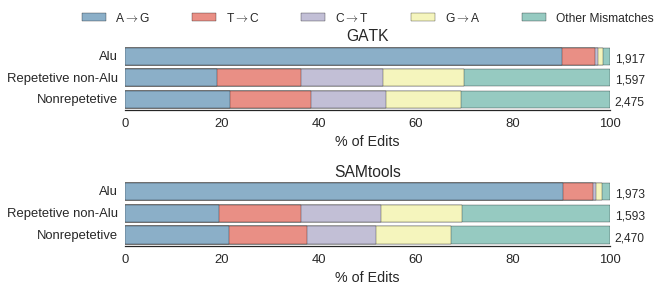

In [17]:
sns.set(style="white",font_scale=1.3)    
colors=[4]
nt=["A","C","G","T"]
etypes=[]
for i in nt:
    for j in nt:
        if i!=j:
            etypes.append(i+j)
rgn_name={"Alu": "Alu","nonAlu-reps":"Repetetive non-Alu","nonreps":"Nonrepetetive"}
bin_labels=[r"A$\rightarrow$G",r"T$\rightarrow$C",r"C$\rightarrow$T",r"G$\rightarrow$A","Other Mismatches"]
my_colors=sns.color_palette("Set3",n_colors=10)
fig, axes = plt.subplots(2,1,figsize=(9,4))        
for ii,caller in enumerate(callers) :
    ax=axes[ii]
    res=[]
    labels=[]
    n={}
    for rrr,rgn in enumerate(["Alu","nonAlu-reps","nonreps"]):                        
        my_dist=edit_distrbution_all[caller]
        if set(my_dist["FP"]["good"][rgn].keys())-set(etypes):
            print aaaa
        z=[my_dist["FP"]["good"][rgn][k] if k in 
           my_dist["FP"]["good"][rgn] else 0 
           for k in etypes]

        sz=sum(z)+0.000001
        z=map(lambda x:round(x/float(sz),4)*100,z)
        z=[z[1],z[10],z[5],z[6],z[0]+sum(z[2:5])+sum(z[7:10])+z[11]]
        res_bin=[sum(z),sum(z[:4]),sum(z[:3]),sum(z[:2]),z[0]]
        res.append(res_bin)
        label=rgn_name[rgn]
        n[label]=int(sz)
        labels.append(label)
    my_data=DataFrame(np.array(res),index=labels,columns=bin_labels)
    for ii,b in enumerate(bin_labels):
        cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_colors[ii],ax=ax)
    for ii,label in enumerate(labels):
        ax.text(101,ii+.25,"%d,%03d"%(n[label]/1000,n[label]%1000) if n[label]>=1000 else n[label] ,fontsize=12)
    ax.set_xlabel("% of Edits")

    ax.set_xlim([0,100])
    ax.set_title("%s"%(caller.replace("samtools","SAMtools")))
    sns.despine(left=True)    
    handles, labels = ax.get_legend_handles_labels()
axes[0].legend(handles[::-1], labels,bbox_to_anchor=(-.1, 1.3, 1.2, .3), 
      loc=0,ncol=5,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=12)


plt.tight_layout()


# samtools vs GATK

DIFF -7 -1
52708 51002 47502 5213 3501 39983 2564 1344


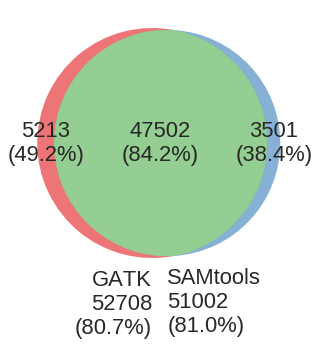

In [18]:
sns.set(style="white",font_scale=1.5)  
fig, ax = plt.subplots(figsize=(4.5,10))
caller1="GATK"
caller2="samtools"
pred1=pred_vcf[caller1]
pred2=pred_vcf[caller2]
n1=pred_res[caller1]["TP"]+pred_res[caller1]["FP"]
n2=pred_res[caller2]["TP"]+pred_res[caller2]["FP"]

my_colors=sns.color_palette("Set1",n_colors=10)

cmd="/bin/bash -c \"java -jar  %s vcfcompare -bed %s.NIST_HC_exon.bed -exclude_filtered -true_vcf <(grep -E '#|PASS' %s) -prefix \
%s/%s_%s/%s_NISTHC %s\""%(varsim_jar,gtf_file,pred1,analysis_folder,caller1,caller2,assembler,pred2)
if not os.path.exists("%s/%s_%s/%s_NISTHC_TP.vcf"%(analysis_folder,caller1,caller2,assembler)):
    a=os.system(cmd)
    print cmd
    if a!=0:
        print a

cmd="/bin/bash -c \"java -jar  %s vcfcompare -bed %s.NIST_HC_exon.bed -exclude_filtered -true_vcf %s \
-prefix %s/%s_%s/NIST_%s_NISTHC %s/%s_%s/%s_NISTHC_TP.vcf\""%(varsim_jar,gtf_file,NIST_vcf,analysis_folder,caller1,caller2,assembler,
                                                             analysis_folder,caller1,caller2,assembler)
if not os.path.exists("%s/%s_%s/NIST_%s_NISTHC_TP.vcf"%(analysis_folder,caller1,caller2,assembler)):
    a=os.system(cmd)
    print cmd
    if a!=0:
        print a


res_file="%s/%s_%s/%s_NISTHC_FN.vcf"%(analysis_folder,caller1,caller2,assembler)
cnt=0
with open(res_file,"r") as res_file_stram:
    for line in res_file_stram:
        if not line[0]=="#":
            cnt+=1
n_only_1=cnt

res_file="%s/%s_%s/%s_NISTHC_FP.vcf"%(analysis_folder,caller1,caller2,assembler)
cnt=0
with open(res_file,"r") as res_file_stram:
    for line in res_file_stram:
        if not line[0]=="#":
            cnt+=1
n_only_2=cnt

res_file="%s/%s_%s/%s_NISTHC_TP.vcf"%(analysis_folder,caller1,caller2,assembler)
cnt=0
with open(res_file,"r") as res_file_stram:
    for line in res_file_stram:
        if not line[0]=="#":
            cnt+=1
n_both=cnt

print "DIFF",n1-n_only_1-n_both,n2-n_only_2-n_both

res_file="%s/%s_%s/NIST_%s_NISTHC_TP.vcf"%(analysis_folder,caller1,caller2,assembler)
cnt=0
with open(res_file,"r") as res_file_stram:
    for line in res_file_stram:
        if not line[0]=="#":
            cnt+=1

t_both=cnt
t_only_1=pred_res[caller1]["TP"]-t_both
t_only_2=pred_res[caller2]["TP"]-t_both
print n1,n2,n_both,n_only_1,n_only_2,t_both,t_only_1,t_only_2

# res_file="%s/%s/%s_%s/NIST_%s_%s_FN.vcf"%(output_folder,sample,caller1,caller2,tool,mod)
# cnt=0
# with open(res_file,"r") as res_file_stram:
#     for line in res_file_stram:
#         if not line[0]=="#":
#             cnt+=1
# T=t_both+cnt
#print n1,n2,n_both,n_only_1,n_only_2
v = venn2(subsets=[n_only_1,n_only_2,n_both], 
          set_labels = ('A','B'),ax=ax,alpha=0.6,set_colors=(my_colors[0],my_colors[1]))
v.get_label_by_id('10').set_text("%s\n(%0.1f%%)"%(n_only_1,t_only_1/float(n_only_1)*100))
v.get_label_by_id('01').set_text("%s\n(%0.1f%%)"%(n_only_2,t_only_2/float(n_only_2)*100))
v.get_label_by_id('11').set_text("%s\n(%0.1f%%)"%(n_both,t_both/float(n_both)*100))
v.get_label_by_id('A').set_text('%s\n%s\n(%0.1f%%)'%(caller1,n1,
                                                  pred_res[caller1]["TP"]/float(n1)*100))
v.get_label_by_id('B').set_text('%s\n%s\n(%0.1f%%)'%("SAMtools",n2,
                                                  pred_res[caller2]["TP"]/float(n2)*100))
for labe_id in ["10","01","11","A","B"]:
    v.get_label_by_id(labe_id).set_fontsize(22)
v.get_patch_by_id("11").set_color(my_colors[2])

plt.tight_layout()


## Check genotypes on TP

In [19]:
for caller in callers:
    pred=pred_vcf[caller]
    for mod in ["NISTHC","StringTie_NISTHC"]:
        if mod=="NISTHC":
            true_bed=NIST_HC_exon_bed
        elif "StringTie" in mod:
            true_bed="%s.NIST_HC_exon.bed"%gtf_file

        cmd="java -jar %s vcfcompare -bed %s -exclude_filtered -match_geno -true_vcf %s -prefix \
        %s.%s_GT %s"%(varsim_jar,true_bed,NIST_vcf,pred_vcf[caller],mod,pred)
        if not os.path.exists("%s.%s_GT_TP.vcf"%(pred_vcf[caller],mod)):
            a=os.system(cmd)
            print cmd
            if a!=0:
                print a


In [20]:
for caller in callers:
    pred=pred_vcf[caller]
    cmd="java -jar %s vcfcompare -bed %s.NIST_HC_exon.bed -exclude_filtered -match_geno \
    -true_vcf %s -prefix %s_%s_NISTHC_GT %s"%(varsim_jar,gtf_file,NIST_vcf,pred,assembler,pred)
    if not os.path.exists("%s_%s_NISTHC_GT_TP.vcf"%(pred,assembler)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print a
            
    cmd="java -jar %s vcfcompare -bed %s -exclude_filtered -match_geno \
    -true_vcf %s -prefix %s_NISTHC_GT %s"%(varsim_jar,NIST_HC_exon_bed,NIST_vcf,pred,pred)
    if not os.path.exists("%s_NISTHC_GT_TP.vcf"%(pred)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print a            

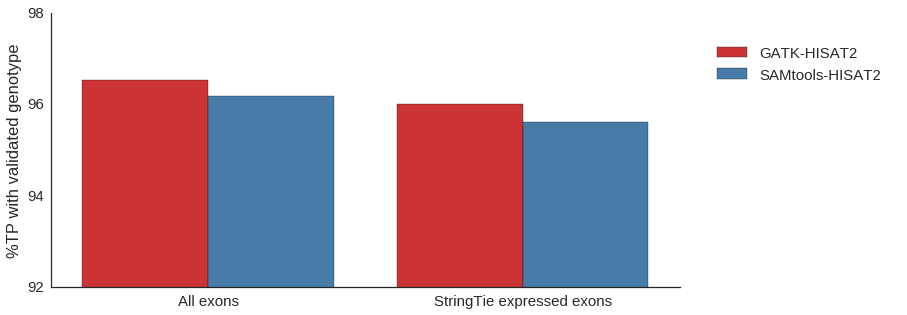

In [21]:
sns.set(style="white",font_scale=1.5)  
title_dict={"NISTHC":"All exons",
            "Cufflinks_NISTHC":"Cufflinks expressed exons",
            "StringTie_NISTHC":"StringTie expressed exons"}
data=[]
for mod in ["NISTHC","StringTie_NISTHC"]:
    for caller in callers:
        res_file="%s_%s_GT_TP.vcf"%(pred_vcf[caller],mod)
        cnt1=0
        with open(res_file,"r") as res_file_stram:
            for line in res_file_stram:
                if not line[0]=="#":
                    cnt1+=1
        res_file="%s_%s_TP.vcf"%(pred_vcf[caller],mod)
        cnt2=0
        with open(res_file,"r") as res_file_stram:
            for line in res_file_stram:
                if not line[0]=="#":
                    cnt2+=1
        z=round(cnt1/float(cnt2),4)
        label="%s-%s"%(caller,tool)
        label=label.replace("Tophat","TopHat")
        label=label.replace("samtools","SAMtools")
        data.append([label,title_dict[mod],z*100])
                    
my_data=DataFrame(data,columns=["Variant Caller","mod","%TP with validated genotype"])

cg = sns.factorplot(x="mod", y="%TP with validated genotype", hue="Variant Caller", data=my_data,
                   size=5, kind="bar", palette=my_colors
                    ,aspect=2,legend=False)
yticks(range(92,100,2))
ylim([92,98])
xlabel("")
legend(bbox_to_anchor=(1.05, 0.8, .3, .102), loc=2,ncol=1,
          mode="expand", borderaxespad=0.,frameon=False)
